In [1]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import random
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

import os
import json
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torch.optim as optim

In [2]:
# Globals
BATCH_SIZE = 8
NUM_CLASSES = 50
CONF_THRESHOLD = 0.85
EPOCHS = 50
IMAGE_SIZE = 224
MODEL_SAVE_DIR = 'saved_models'

torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 128, 128])


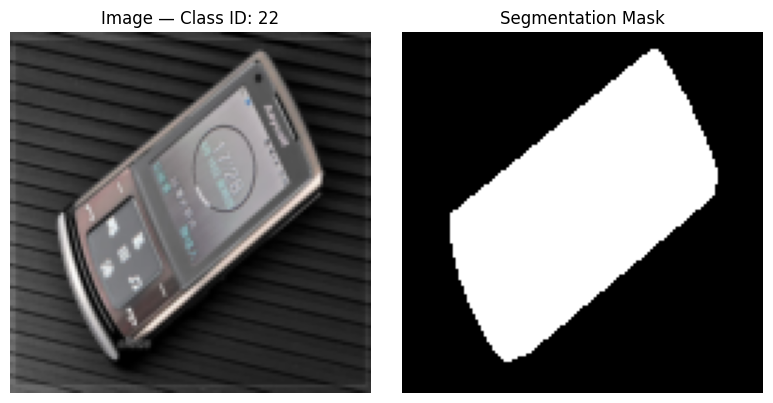

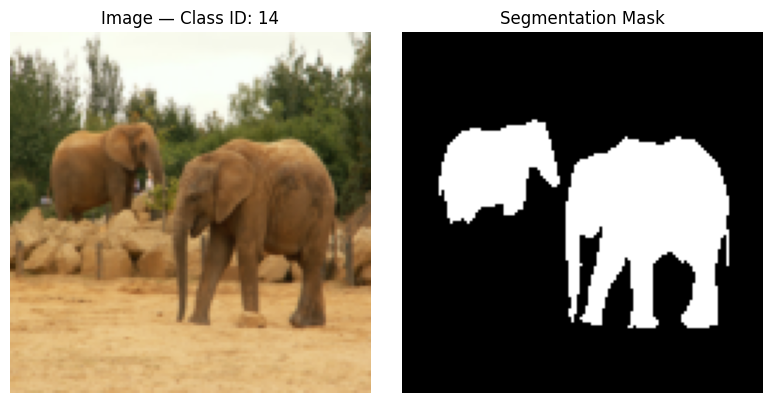

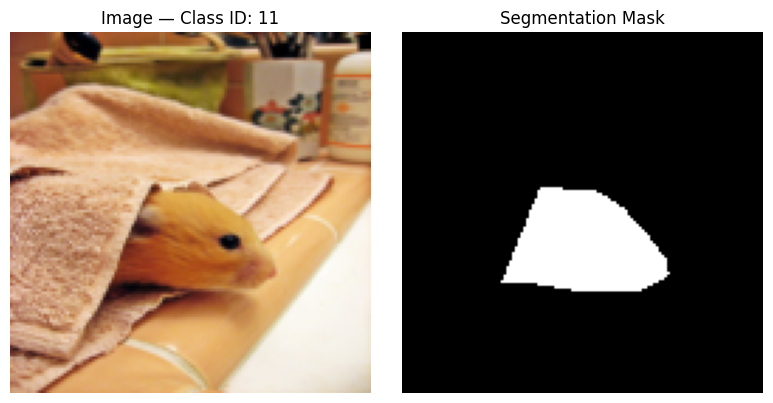

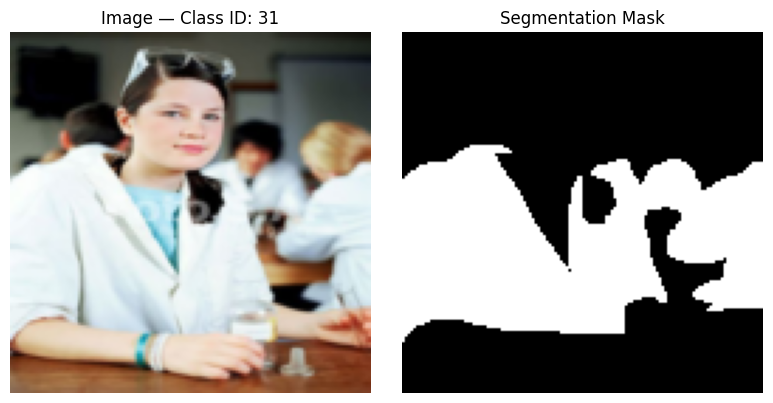

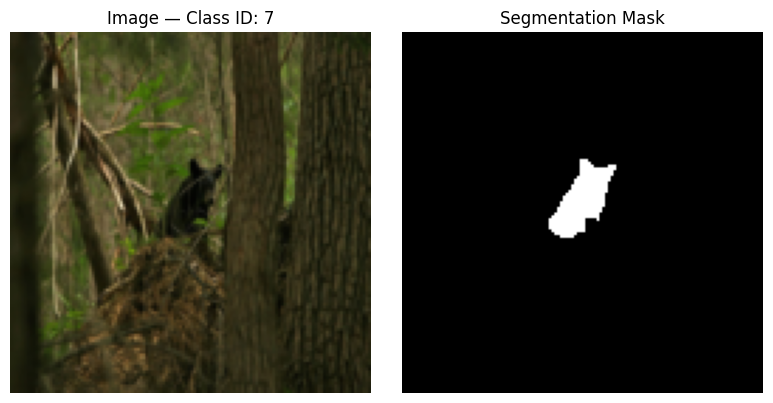

In [ ]:
class ImageNetSubsetSegmentationDataset(Dataset):
    def __init__(self, json_path, image_size=(128, 128), mode='both'):
        """
        mode: 'classification' | 'segmentation' | 'both'
        """
        self.image_dir = "train-semi"
        self.mask_dir = "train-semi-segmentation"
        self.mode = mode
        self.image_size = image_size

        with open(json_path, "r") as f:
            self.samples = json.load(f)

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

        self.mask_transform = transforms.Resize(image_size, interpolation=Image.NEAREST)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image_rel = entry["image"]
        mask_rel = entry["mask"]
        class_id = entry["class_id"]

        # Resolve image path
        image_path = os.path.join(self.image_dir, image_rel)
        if not os.path.exists(image_path):
            pattern = os.path.splitext(image_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                image_path = matches[0]
            else:
                raise FileNotFoundError(f"Image not found: {image_rel}")

        # Resolve mask path
        mask_path = os.path.join(self.mask_dir, mask_rel)
        if not os.path.exists(mask_path):
            pattern = os.path.splitext(mask_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                mask_path = matches[0]
            else:
                raise FileNotFoundError(f"Mask not found: {mask_rel}")

        # Load image
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        if self.mode == "classification":
            return image, class_id

        # Load and process mask safely
        # Load and process mask (convert RGB to single-channel integer label map)
        mask = Image.open(mask_path).convert("RGB")  # keep RGB to handle RGB masks

        # Convert to numpy array and pick one channel
        mask_np = np.array(mask)
        # If mask is RGB but grayscale-like, all channels will be equal – take just one
        if mask_np.ndim == 3 and mask_np.shape[2] == 3:
            mask_np = mask_np[:, :, 0]  # take R channel (any would work if R=G=B)

        # Resize with nearest interpolation
        mask = Image.fromarray(mask_np.astype(np.uint8)).resize(self.image_size, resample=Image.NEAREST)

        # Convert to tensor
        mask = torch.from_numpy(np.array(mask)).long()  # shape (H, W)

        if self.mode == "segmentation":
            return image, mask

        if self.mode == "both":
            return image, class_id, mask

# Plot function
def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(to_pil_image(image))
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask, cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.imshow(mask, cmap='gray')

# Load dataset
dataset = ImageNetSubsetSegmentationDataset(
    json_path="train_semi_annotations_with_seg_ids.json",
    mode='both'
)

# DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Inspect one batch
images, class_ids, masks = next(iter(dataloader))
print(images.shape)     # [16, 3, 128, 128]
print(class_ids.shape)  # [16]
print(masks.shape)      # [16, 128, 128]

for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])


In [4]:
# --- Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.dec2 = conv_block(256, 128)
        self.dec1 = conv_block(128, 64)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.up2(e3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

class SimpleUNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # [B, 16, 64, 64]
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # [B, 32, 32, 32]
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # [B, 16, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(16, num_classes, 2, stride=2)  # [B, num_classes, 128, 128]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # logits [B, num_classes, H, W]


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model = UNet(in_channels=3, out_channels=233).to(device)
# model = SimpleUNet(232 + 1).to(device)
criterion = nn.CrossEntropyLoss()  # expects (B, C, H, W) logits and (B, H, W) target
optimizer = optim.Adam(model.parameters(), lr=1e-3)

using cuda


In [6]:
from collections import Counter

max_label = 0
label_counts = Counter()

for _, _, masks in dataloader:
    max_label = max(max_label, masks.max().item())
    label_counts.update(masks.view(-1).tolist())

print(f"Max label found: {max_label}")
print(f"Some label counts: {dict(list(label_counts.items())[:10])}")

Max label found: 232
Some label counts: {0: 5582975, 16: 61679, 18: 67129, 9: 13458, 12: 42667, 25: 71192, 20: 71586, 41: 67188, 47: 28202, 44: 44473}


In [7]:
from torch.utils.data import DataLoader
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_fg = preds[:, 1:, :, :]  # skip background
        targets_onehot = F.one_hot(targets, num_classes=preds.shape[1]).permute(0, 3, 1, 2)
        targets_fg = targets_onehot[:, 1:, :, :].float()
        intersection = (preds_fg * targets_fg).sum()
        union = preds_fg.sum() + targets_fg.sum()
        return 1 - (2. * intersection + self.smooth) / (union + self.smooth)

def combined_loss(preds, targets):
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + 0.5 * dice

# train_dataset = SegmentationDataset(img_dir, mask_dir, transform, target_transform)
# dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)  # [B, num_classes, H, W]
        loss = combined_loss(outputs, masks)  # masks: [B, H, W]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")


Epoch [1/10], Loss: 169.0298
Epoch [2/10], Loss: 131.7459
Epoch [3/10], Loss: 100.6610
Epoch [4/10], Loss: 81.3140
Epoch [5/10], Loss: 75.1018
Epoch [6/10], Loss: 72.5789
Epoch [7/10], Loss: 71.9511
Epoch [8/10], Loss: 72.5349
Epoch [9/10], Loss: 71.0442
Epoch [10/10], Loss: 70.2992


Unique predicted classes: tensor([0])


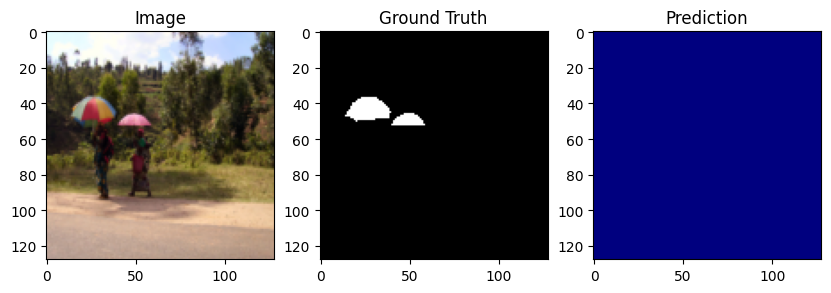

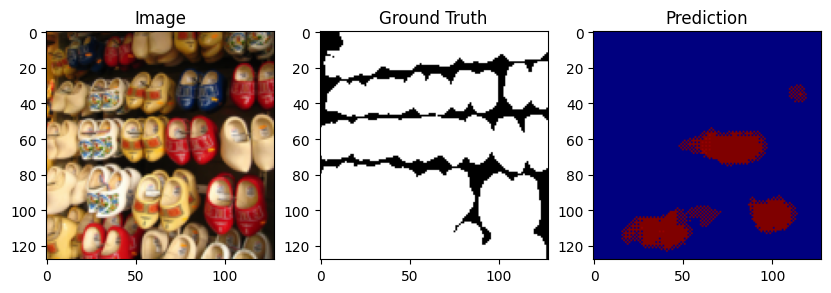

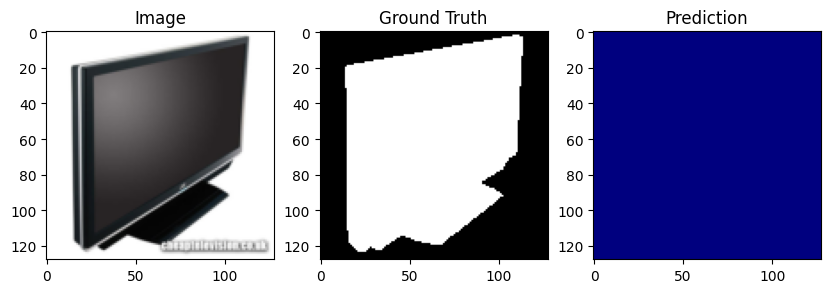

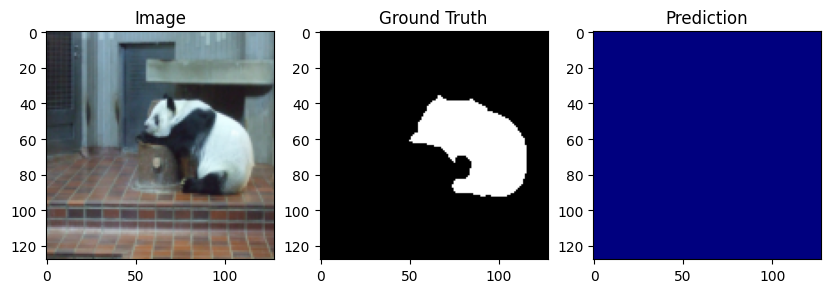

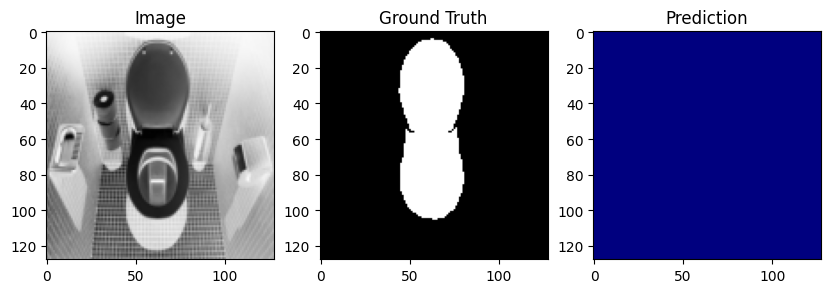

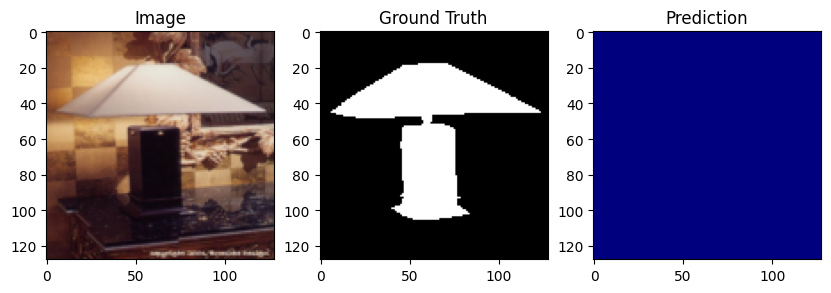

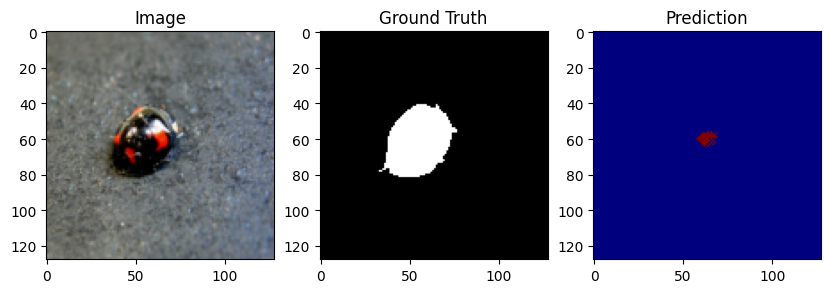

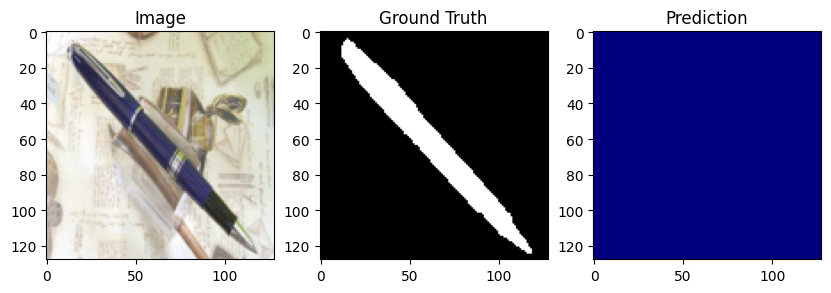

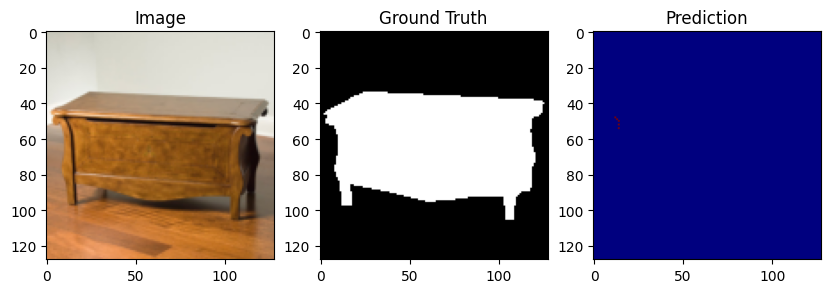

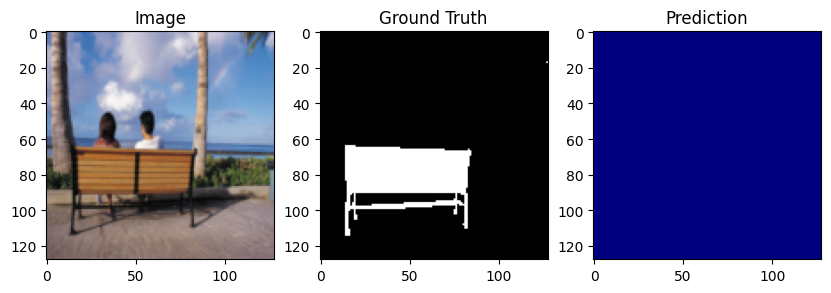

In [8]:
model.eval()
with torch.no_grad():
    images, class_ids, masks = next(iter(dataloader))
    images = images.to(device)
    preds = model(images)  # [B, num_classes, H, W]
    preds = torch.argmax(preds, dim=1).cpu()  # [B, H, W]
    print("Unique predicted classes:", torch.unique(preds[0]))

# Visualize the first one
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(images[i].cpu()))
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(masks[i].cpu(), cmap="gray")
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(preds[i], cmap="jet")
    plt.title("Prediction")
    plt.show()
